In [1]:
from scipy.optimize import minimize
import joblib
import numpy as np
from sklearn.preprocessing import StandardScaler
# %run 1.Sobol_sequence.ipynb
%run 2.Hicks_Henne_NEW_Final.ipynb
# %run 3.Deformed_foil_generator.ipynb
# %run 4.Xfoil_runner_extract_value.ipynb
# %run 5.ANN_MODEL.ipynb

In [2]:
model = joblib.load('model__01.joblib')
scaler = joblib.load('scaler_file__01.joblib')

C:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.2.2 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
feature_names = ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]

In [13]:
def objective_function(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]
    
    efficiency = CL / CD
    return -efficiency

def constraint(design_parameters):
    design_parameters = design_parameters.reshape(1,8)
    design_parameters = pd.DataFrame(design_parameters, columns=feature_names)
    design_parameters = scaler.transform(design_parameters)
    
    predictions = model.predict(design_parameters)
    CL = predictions[0, 0]
    CD = predictions[0, 1]
    
    original_CD = 0.00848  
    
    return original_CD - CD
    
def area_constraint(design_parameters):
    design_parameters = np.array(design_parameters).reshape((1, 8))
    i = 0
    y_mod = hicks_henne_overall(x, y , n, design_parameters, i, w, xM)
    polygon1 = Polygon(zip(x, y))
    area_orig = polygon1.area
    polygon2 = Polygon(zip(x, y_mod))
    area_mod = polygon2.area
    return area_orig - area_mod




In [14]:
bounds = [(-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01), (-0.01, 0.01) ]
#scale
initial_guess = np.full(8,0)

In [15]:
from shapely.geometry import Polygon
constraints = [{'type': 'ineq', 'fun': constraint},{'type': 'eq', 'fun': area_constraint}]

result = minimize(objective_function, initial_guess, bounds=bounds, constraints=constraints, method='SLSQP')

optimal_design_parameters = result.x

1/1 [==============================] - 0s 25ms/step


In [16]:
if result.success:
    print("Optimization successful!")
else:
    print("Optimization failed. Message:", result.message)

Optimization successful!


In [17]:
optimal_design_parameters = np.array(optimal_design_parameters).reshape((1, 8))
optimal_design_parameters_df = pd.DataFrame(optimal_design_parameters, columns=feature_names)
optimal_design_parameters_scaled = scaler.transform(optimal_design_parameters_df)
Optimized = model.predict(optimal_design_parameters_scaled)
CL_opt = Optimized[0, 0]
CD_opt = Optimized[0, 1]
optimal_efficiency = CL_opt/CD_opt
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient:", CL_opt )
print("Optimal Drag Coefficient:", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)

1/1 [==============================] - 0s 27ms/step
Optimal Design Parameters: [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]
Optimal Lift Coefficient: 0.8109723
Optimal Drag Coefficient: 0.008171556
Optimal Aerodynamic Efficiency: 99.24332


In [18]:
optimal_design_parameters

array([[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]])

In [22]:
i = 0

In [23]:
y_opt = hicks_henne_overall(x, y , n, optimal_design_parameters, i, w, xM)

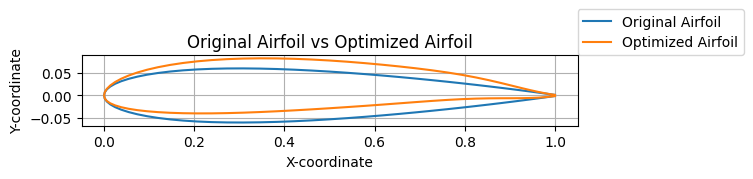

In [24]:
plt.plot(x, y, label = "Original Airfoil")
plt.plot(x, y_opt, label = "Optimized Airfoil")
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Original Airfoil vs Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.legend(loc=(1,1))
plt.grid()

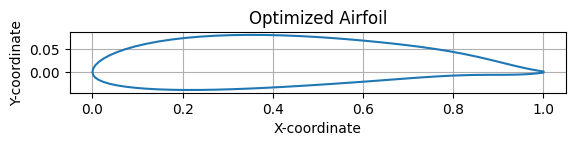

In [25]:
plt.plot(x,y_opt)
plt.gca().set_aspect('equal', adjustable='box')
plt.title('Optimized Airfoil')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.grid()

In [26]:
df_opt = pd.DataFrame({'x': x, 'y_modified': y_opt})
path = "Optimized_airfoil.dat"
df_opt.to_csv(path, index=False, sep=' ')

In [27]:
import os
import subprocess
import numpy as np
import pandas as pd
import time
import warnings

In [28]:
# %% Inputs
# alpha_i = 0
# alpha_f = 5
# step = 1
alpha = 5
Re = 1000000
# Mach = 0.2
n_iter = 20
# n_panels = 200

In [29]:
airfoil_name = "Optimized_airfoil"

if os.path.exists("polar_file.txt"):
    os.remove("polar_file.txt")
    
input_file = open("input_file.in", 'w')
input_file.write("LOAD {0}.dat\n".format(airfoil_name))
input_file.write(airfoil_name + '\n')
#     input_file.write("PANE\nN {0}".format(n_panels))
input_file.write("PANE\n")
input_file.write("OPER\n")
input_file.write("Visc {0}\n".format(Re))
#     input_file.write("Mach {0}\n".format(Mach))
input_file.write("PACC\n")
input_file.write("polar_file.txt\n\n")
input_file.write("ITER {0}\n".format(n_iter))
#     input_file.write("Aseq {0} {1} {2}\n".format(alpha_i,alpha_f,step))
input_file.write("Alfa {0}\n".format(alpha))
input_file.write("\n\n")
input_file.write("quit\n")
input_file.close()

subprocess.call(f'xfoil.exe < input_file.in & echo quit', shell=True)

time.sleep(0.5)

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")

    # Try to load data from the file
    polar_data = np.loadtxt("polar_file.txt", skiprows=12)

    # Check for the specific UserWarning
    for warning in w:
        if issubclass(warning.category, UserWarning) and "input contained no data" in str(warning.message):
#                 print(f"Warning encountered in iteration {i}: {warning.message}")
            break  # Stop checking for warnings once the relevant one is found

if len(polar_data)==0:
    CL = np.nan
    CD = np.nan
    print("-------->","NaN","NaN")

else:
    CL = polar_data[1]
    CD = polar_data[2]
    print("-------->",CL,CD)
    print("-------->",CL/CD)
    

--------> 0.8662 0.00833
--------> 103.98559423769507


In [30]:
print('Surrogate model optimization:')
print("Optimal Design Parameters:", optimal_design_parameters)
print("Optimal Lift Coefficient(Surrogate model prediction):", CL_opt )
print("Optimal Drag Coefficient(Surrogate model prediction):", CD_opt)
print("Optimal Aerodynamic Efficiency:", optimal_efficiency)
print("Lift Coefficient for Optimal Design Parameter from XFOIL:", CL )
print("Drag Coefficient for Optimal Design Parameter from XFOIL:", CD)
Opt_eff = CL/CD
print("Optimal Aerodynamic Efficiency from XFOIL:", Opt_eff)

Surrogate model optimization:
Optimal Design Parameters: [[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]
Optimal Lift Coefficient(Surrogate model prediction): 0.8109723
Optimal Drag Coefficient(Surrogate model prediction): 0.008171556
Optimal Aerodynamic Efficiency: 99.24332
Lift Coefficient for Optimal Design Parameter from XFOIL: 0.8662
Drag Coefficient for Optimal Design Parameter from XFOIL: 0.00833
Optimal Aerodynamic Efficiency from XFOIL: 103.98559423769507


In [31]:
print("Error%")
print("Lift Coefficient Error:", abs((CL_opt-CL)*100/CL))
print("Drag Coefficient Error:", abs((CD_opt-CD)*100/CD))
print("Optimal Aerodynamic Efficiency Error:", abs((Opt_eff-optimal_efficiency)*100/Opt_eff))

Error%
Lift Coefficient Error: 6.3758631551879485
Drag Coefficient Error: 1.9020938036107
Optimal Aerodynamic Efficiency Error: 4.560514003953592


In [32]:
CL_org = 0.5572
CD_org = 0.00848
Org_Eff = CL_org/CD_org
print("Improvement in Efiiciency")
print("Lift and Drag Coefficient of Original Airfoil:", CL_org , CD_org)
print("Efiiciency of Original Airfoil:", CL_org/CD_org)
print("Lift and Drag Coefficient of Optimized Airfoil:", CL ,CD)
print("Efiiciency of Optimized Airfoil:", Opt_eff)
print("Improvement in Efiiciency:", abs((Opt_eff-Org_Eff)*100/Org_Eff),"%")

Improvement in Efiiciency
Lift and Drag Coefficient of Original Airfoil: 0.5572 0.00848
Efiiciency of Original Airfoil: 65.70754716981132
Lift and Drag Coefficient of Optimized Airfoil: 0.8662 0.00833
Efiiciency of Optimized Airfoil: 103.98559423769507
Improvement in Efiiciency: 58.255175724273904 %


In [34]:
polygon1 = Polygon(zip(x, y))
area_orig = polygon1.area
area_orig

0.08212661066699999

In [35]:
polygon2 = Polygon(zip(x, y_opt))
area_opt = polygon2.area
area_opt

0.08212661066699997